In [1]:
import xarray as xr
import importlib
import interpolate_outputs
import os
import numpy as np
from utility_programs.read_routines import SAMI
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator
from datetime import datetime
import gc
import dask

/glade/work/abukowski/conda-envs/SAMI3-GITM/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
spath = '/glade/scratch/abukowski/simstorm-20110521/GITM-simstorm-run1/sami-gitm-coupled-lores/'

In [3]:
interpolate_outputs = importlib.reload(interpolate_outputs)

In [4]:
ds0 = interpolate_outputs.do_interpolations(spath,
                                            out_path='/glade/scratch/abukowski/postprocessed/',
                                            out_runname='LND_interpolated2-new-cart',
                                            dtime_sim_start='20110520',
                                            cols='edens',
                                            engine='h5netcdf',
                                            return_ds_too=True,
                                            save_delauney=False,
                                            show_progress=True)

Calculating Delauney Triangulation..


writing Dataset...: : 625it [05:38,  1.84it/s]                              


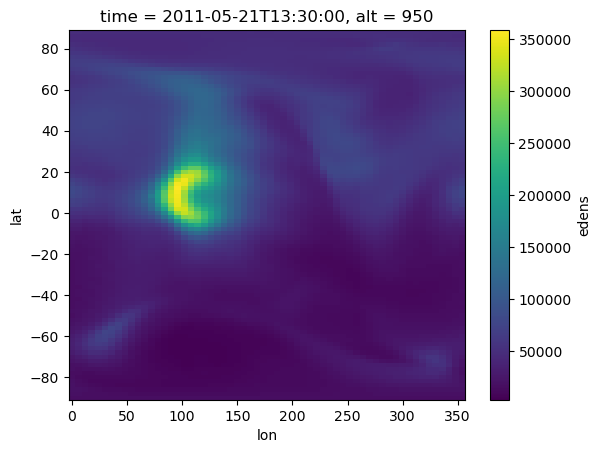

In [5]:
ds0.edens.isel(time=450, alt=15).plot(x='lon')

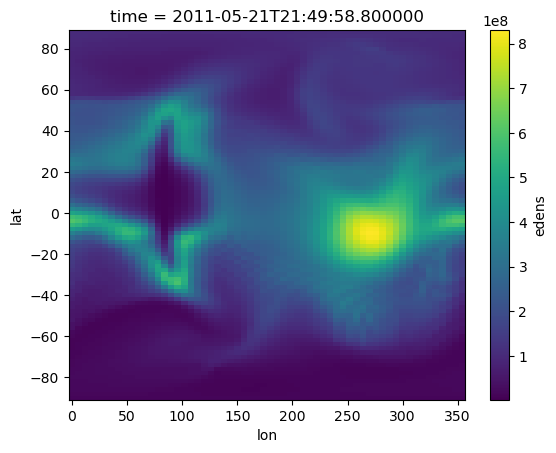

In [6]:
ds0.edens.isel(time=550).integrate('alt').plot(x='lon')

In [7]:
dask.is_dask_collection(ds0)

False

In [8]:
ds1 = xr.open_mfdataset('/glade/scratch/abukowski/postprocessed/LND_interpolated2-new-cart_SAMI_REGRID.nc', engine='h5netcdf')

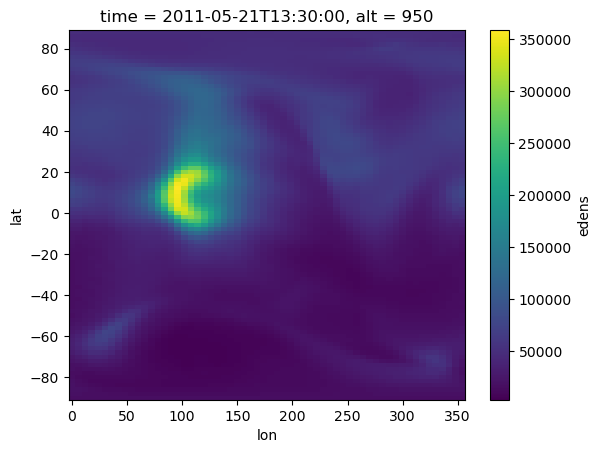

In [9]:
ds1.edens.isel(time=450, alt=15).plot(x='lon')

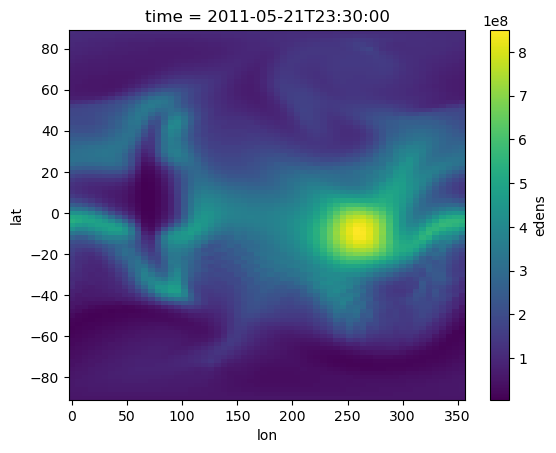

In [12]:
ds1.edens.isel(time=570).integrate('alt').plot(x='lon')

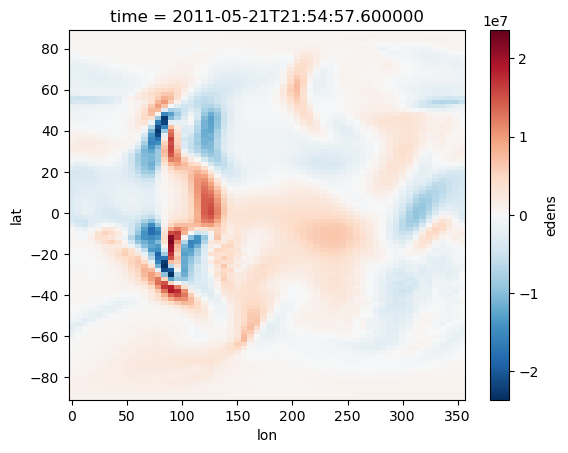

In [11]:
ds1.edens.diff('time').isel(time=550).integrate('alt').plot(x='lon')

# Debugging the code...

In [40]:
latout = np.arange(-90, 90, 2)
lonout = np.arange(0, 360, 6)
# altout = np.arange(200, 2200, 50)
altout = np.arange(400, 700, 50)
out_lats, out_lons, out_alts = np.meshgrid(latout, lonout, altout)



In [41]:
out_lon_lat_alt = interpolate_outputs.gps_to_ecef_custom(
    out_lons.flatten(), out_lats.flatten(), out_alts.flatten()).T

In [42]:
nz, nf, nlt, nt = SAMI.get_grid_elems_from_parammod(spath)

In [43]:
grid = SAMI.get_sami_grid(spath, nlt, nf, nz)

In [45]:
grid2 = {}
mask = np.where((grid['alt'] < 750) & (grid['alt'] > 350))
for k in grid.keys():
    grid2[k] = grid[k][mask].flatten()
del grid

In [46]:
in_cart = interpolate_outputs.gps_to_ecef_custom(grid2['glon'],
                            grid2['glat'],
                            grid2['alt']).T

In [47]:
in_cart.shape

(211760, 3)

In [48]:
out_lon_lat_alt.shape

(32400, 3)

In [49]:
tri = Delaunay(in_cart)

In [51]:
data, times = SAMI.read_to_nparray(
                spath, datetime(2011,5,20),
                cols='edens', t_end_idx=30,
                skip_time_check=True)

In [69]:
interpd = []
for t in range(len(times)):
    interp = LinearNDInterpolator(
        tri,
        data['data']['edens'][:, :, :, t][mask].flatten())
    interpd.append(interp(out_lon_lat_alt))
    if t > 10:
        break

In [70]:
ds = xr.Dataset(coords={
                'time': (['time'], times[:len(interpd)]),
                'alt': (['alt'], altout),
                'lon': (['lon'], lonout),
                'lat': (['lat'], latout)},)
ds['ed'] = (('time', 'lon', 'lat', 'alt'),
                np.array(interpd).reshape(
                    len(interpd),
                    len(lonout),
                    len(latout),
                    len(altout)))

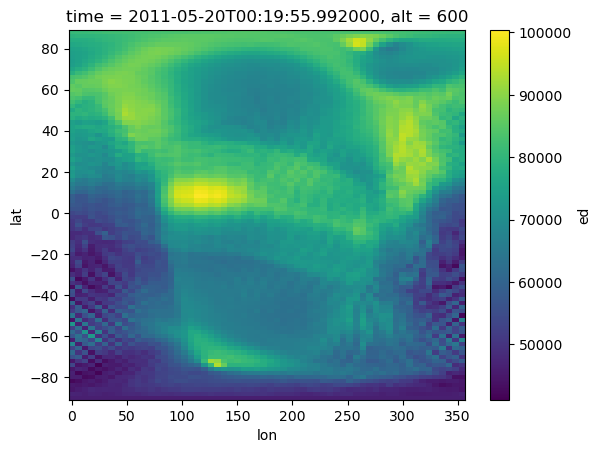

In [71]:
ds.ed.isel(time=4, alt=4).plot(x='lon')